# Forex predictions using Machine Learning
# Loading and preparing data

In [1]:
import pandas as pd
df = pd.read_csv("MBSS Historical Data.csv")
df.tail()

,Date,close,open,high,low,volume,Unnamed: 6
156,1/9/2023,0.610,0.615,0.615,0.605,1.10M,NaN
157,1/6/2023,0.605,0.605,0.610,0.600,3.65M,NaN
158,1/5/2023,0.610,0.605,0.615,0.605,3.18M,NaN
159,1/4/2023,0.610,0.615,0.615,0.605,2.78M,NaN
160,1/3/2023,0.615,0.620,0.620,0.610,3.91M,NaN


In [2]:
#Check if any zero volumes are available
indexZeros = df[ df['volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["volume"] == 0 )]
df.isna().sum()

Date            0
close           0
open            0
high            0
low             0
volume          0
Unnamed: 6    161
dtype: int64

In [3]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

NameError: name 'df' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Plot ATR
plt.figure(figsize=(10, 6))
plt.plot( df.ta.atr.index, df['ATR'], label='ATR', color='blue')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.title('ATR Over Time')
plt.legend()
plt.show()


In [28]:
df.tail()

,Date,close,open,high,low,volume,Unnamed: 6,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
156,1/9/2023,0.610,0.615,0.615,0.605,1.10M,NaN,0.010708,53.243842,0.610,0.605625,0.613375,NaN,0.000582,-0.000421,NaN,-0.000071,0.147587,NaN
157,1/6/2023,0.605,0.605,0.610,0.600,3.65M,NaN,0.010672,48.124982,0.605,0.605625,0.612812,NaN,0.000414,-0.000457,NaN,-0.000857,-0.961894,NaN
158,1/5/2023,0.610,0.605,0.615,0.605,3.18M,NaN,0.010639,52.991973,0.610,0.605625,0.612375,NaN,0.000257,-0.000486,NaN,-0.000286,-0.403203,NaN
159,1/4/2023,0.610,0.615,0.615,0.605,2.78M,NaN,0.010607,52.991973,0.610,0.605750,0.612000,0.654281,0.000129,-0.000498,NaN,0.000286,0.188597,NaN
160,1/3/2023,0.615,0.620,0.620,0.610,3.91M,NaN,0.010576,57.605003,0.615,0.605875,0.611750,0.653531,0.000082,-0.000443,NaN,0.001571,1.472510,NaN


# Target categories

In [29]:
#Target flexible way
pipdiff = 500*1e-5 #for TP 用于计算止盈（TP）的差价
SLTPRatio = 2 #pipdiff/Ratio gives SL  用于计算止损（SL）的比率，SL = pipdiff / SLTPRatio

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length  # 创建一个与输入数据等长的趋势目标列表
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [30]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.head()

,Date,close,open,high,low,volume,Unnamed: 6,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
0,08/30/2023,0.735,0.735,0.755,0.730,19.36M,NaN,NaN,NaN,0.7425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,08/29/2023,0.735,0.750,0.750,0.725,11.02M,NaN,NaN,NaN,0.7375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,08/28/2023,0.745,0.735,0.750,0.730,9.28M,NaN,NaN,NaN,0.7400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,08/25/2023,0.730,0.725,0.735,0.720,7.96M,NaN,NaN,NaN,0.7275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,08/24/2023,0.725,0.725,0.725,0.720,5.04M,NaN,NaN,NaN,0.7225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


# Quick analysis example

C:\Users\jenqyang.lim\AppData\Local\Temp\ipykernel_35816\2271519335.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


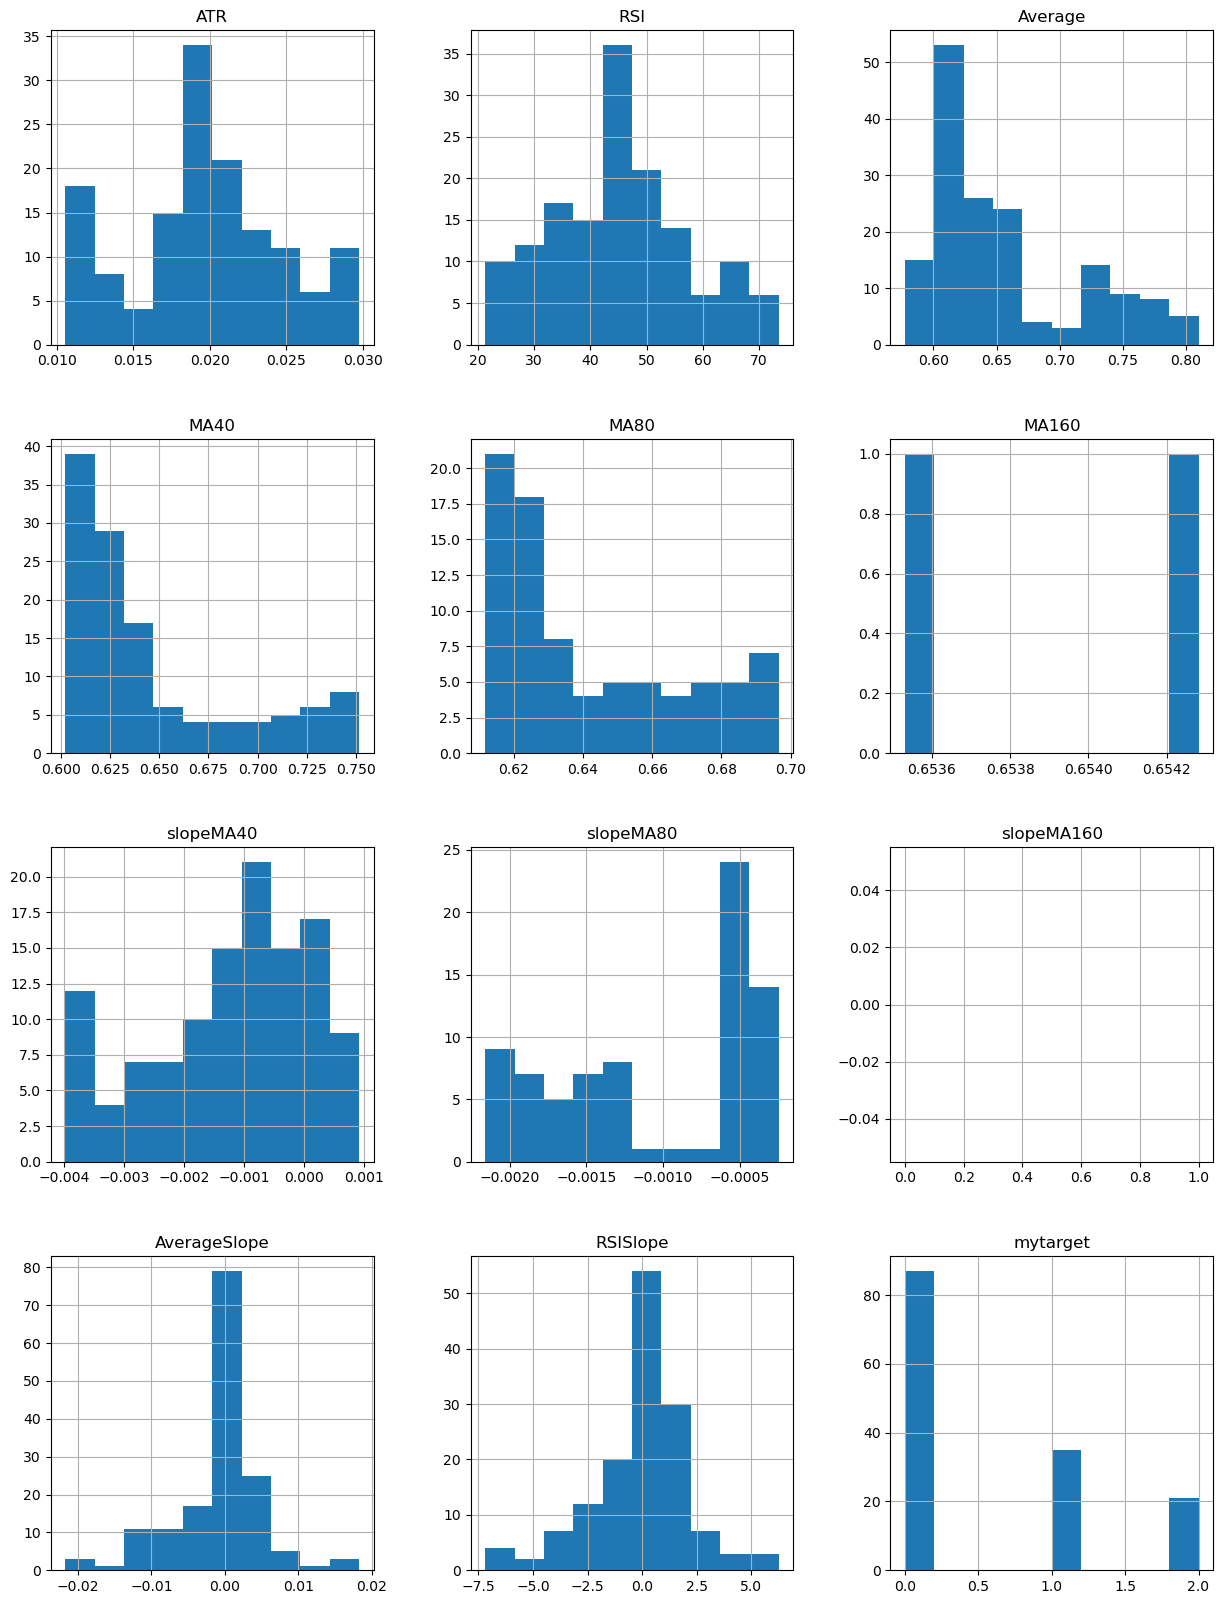

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

## Can we use the RSI alone as a trend indicator?

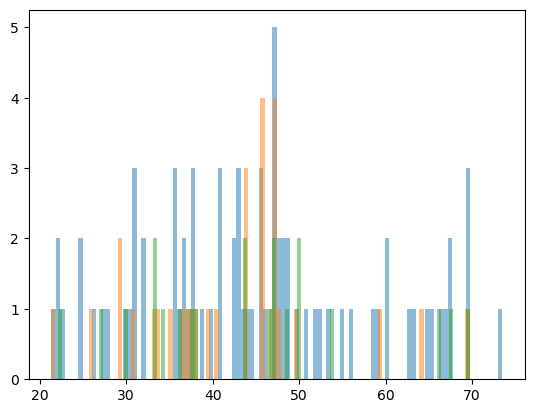

<Figure size 600x600 with 0 Axes>

C:\Users\jenqyang.lim\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jenqyang.lim\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jenqyang.lim\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jenqyang.lim\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


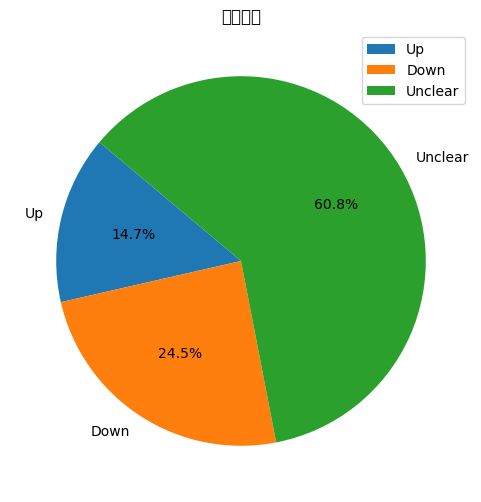

<Figure size 600x600 with 0 Axes>

In [32]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')
plt.figure(figsize=(6, 6))

# 创建一个新的图形来绘制饼图
plt.figure(figsize=(6, 6))

# 数据
categories = ['Up', 'Down', 'Unclear']
values = [len(df_up), len(df_down), len(df_unclear)]

# 绘制饼图
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('数据分布')

pyplot.legend(loc='upper right')
plt.figure(figsize=(6, 6))
categories = ['Up', 'Down', 'Unclear']
values = [len(df_up), len(df_down), len(df_unclear)]

pyplot.show()

#TO SHOW TREND 

# Machine learning for trend prediction

## 1 - the perfect model with precise prediction

## 2 - less perfect model still with > 40% precision

## 3 - much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio 

### can't let an automated program run your trades
### it can be your version of a smart indicator (based on machine learning)

## 4 - Our target has categorical values so we need a classificator, KNN?

## Splitting features and target

In [38]:
import pandas as pd
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

Empty DataFrame
Columns: [ATR, RSI, Average, MA40, MA80, MA160, slopeMA40, slopeMA80, slopeMA160, AverageSlope, RSISlope]
Index: []


In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

ValueError: With n_samples=0, test_size=0.1 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## Fitting the KNN model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [25]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

NameError: name 'y_train' is not defined

## More powerful model XGBoost

In [26]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

ModuleNotFoundError: No module named 'xgboost'

## !!Data sampling shouldn't be random

In [14]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 45.8013%
****Test Results****
Accuracy: 34.8805%


## Which features are most important for our model?

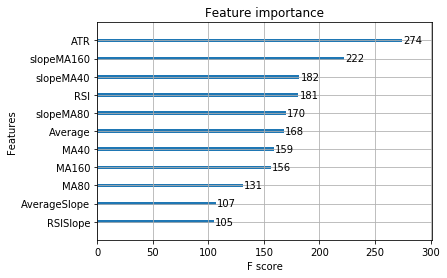

In [15]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

# Automated orders using python and Machine Learning
## Previousavideos
### 1 - Install Anaconda, Jupyter NB, Pandas_TA (Technical Analysis)
### 2 - Download price data from online resources, and add our technical indicators to our exchange price dataframe
### 3 - Fit a Machine learning model and predict future price trends using KNN and XGBOOST classifiers
### 4 - Save and Load a ML model,
### - according to the model's advice
### - passing orders (sell/buy) automatically
### - send an email notification about newly applied trading operations

## Load Machine Learning Model from Disk and Test it

In [19]:
import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

## Live Automated Orders with email notification

In [32]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'


In [30]:
ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

## Executing orders automatically every 4 Hours

In [33]:
#some_job()

###################################################################
## Interval time job ##############################################
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
scheduler.start()

V20Error: {"errorMessage":"Insufficient authorization to perform request."}